## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [3]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [5]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.common)
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

In [6]:
date_str_from='2024-04-01'
date_str_to='2024-04-14'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [7]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [9]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len(all_symbols)

92

In [94]:
dft = pd.read_parquet('/Users/junlim/algo_cache/trading/(momentum_reversal_trading)_feature_param(window(120)_ema_window(30))_selection_size(1)_rebalance_interval_minutes(120)/trading-290017.market_data_gemini.by_minute/2024-05-07T00:00:00-0400_2024-05-08T00:00:00-0400.parquet')

## calculate/cache feature

In [57]:
import algo.feature.momentum.calculate
importlib.reload(algo.feature.momentum.calculate)
import algo.feature.momentum.research
importlib.reload(algo.feature.momentum.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [58]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=180, ema_window=30, 
    filter_out_non_gemini_symbol=True, filter_out_reportable_symbols=True)

In [59]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(180)_ema_window(30)_filter_out_non_gemini_symbol(True)_filter_out_reportable_symbols(True)'

In [61]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(180)_ema_window(30)_filter_out_non_gemini_symbol(True)_filter_out_reportable_symbols(True)'

## momentum reversal

In [97]:
import algo.alpha.momentum_reversal.calculate
importlib.reload(algo.alpha.momentum_reversal.calculate)
import algo.alpha.momentum_reversal.research
importlib.reload(algo.alpha.momentum_reversal.research)
import algo.alpha.momentum_common.research
importlib.reload(algo.alpha.momentum_common.research)

<module 'algo.alpha.momentum_common.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum_common/research.py'>

In [98]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=120, ema_window=30, 
    filter_out_non_gemini_symbol=True, filter_out_reportable_symbols=True)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=1*60)

2390


<AxesSubplot:xlabel='timestamp'>

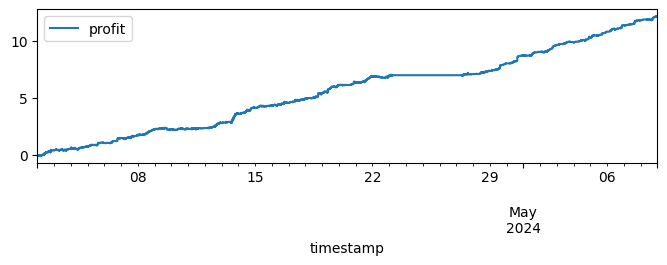

In [114]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-02', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'in_position', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [115]:
fee_pct = 0.25
spread_pct = 0.1
num_trades = len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna())
gross_profit = round(dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().sum().profit, 2)
cost = round(num_trades * 0.01 * (fee_pct + spread_pct), 2)
print(f'{gross_profit=}, {cost=}, net: {round(gross_profit-cost, 2)}')

gross_profit=12.13, cost=8.37, net: 3.76


In [117]:
dfst_trading_reversal[
    (dfst_trading_reversal.profit.fillna(0) != 0) & 
    (dfst_trading_reversal.in_position.shift() == 1)
][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
INJUSD,-0.104364
RENUSD,-0.082465
GALUSD,-0.079648
PEPEUSD,-0.061815
API3USD,-0.044728
ZRXUSD,-0.039696
LRCUSD,-0.033550
SKLUSD,-0.018783
GALAUSD,-0.018060


In [118]:
dfst_trading_reversal[dfst_trading_reversal.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
INJUSD,-0.158802
GALUSD,-0.072935
ZRXUSD,-0.055929
RENUSD,-0.045533
API3USD,-0.042614
SNXUSD,-0.032089
BCHUSD,-0.031422
IMXUSD,-0.018080
GALAUSD,-0.009876


<AxesSubplot:xlabel='timestamp'>

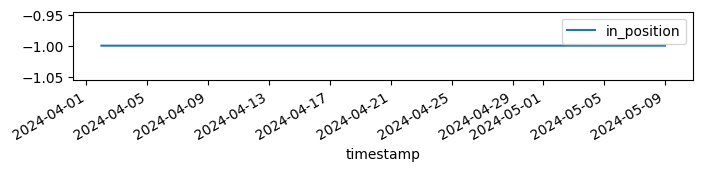

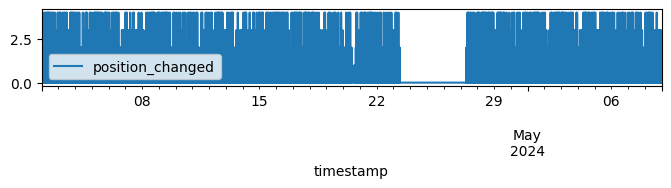

In [122]:
dfst_trading_reversal[
    dfst_trading_reversal.in_position == -1
][['in_position']].groupby('timestamp').sum().plot(figsize=(8,1))
dfst_trading_reversal[['position_changed']].abs().groupby('timestamp').sum().plot(figsize=(8,1))

In [124]:
for _, row in dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-02 00:00:00-04:00, ALIUSD, 0.02748, position_changed: -1.0
2024-04-02 00:00:00-04:00, RAREUSD, 0.182, position_changed: -1.0
2024-04-02 00:00:00-04:00, QRDOUSD, 0.08485, position_changed: 1.0
2024-04-02 00:00:00-04:00, LUNAUSD, 5.321e-05, position_changed: 1.0
2024-04-02 01:00:00-04:00, ELONUSD, 3.02e-07, position_changed: 1.0
2024-04-02 01:00:00-04:00, BATUSD, 0.2969, position_changed: -1.0
2024-04-02 01:00:00-04:00, QRDOUSD, 0.08146, position_changed: -1.0
2024-04-02 01:00:00-04:00, ALIUSD, 0.02748, position_changed: 1.0
2024-04-02 02:00:00-04:00, ZBCUSD, 0.03233, position_changed: -1.0
2024-04-02 02:00:00-04:00, ELONUSD, 2.95e-07, position_changed: -1.0
2024-04-02 02:00:00-04:00, BATUSD, 0.29552, position_changed: 1.0
2024-04-02 02:00:00-04:00, ALIUSD, 0.025391, position_changed: 1.0
2024-04-02 03:00:00-04:00, ZBCUSD, 0.03237, position_changed: 1.0
2024-04-02 03:00:00-04:00, LINKUSD, 18.30308, position_changed: -1.0
2024-04-02 04:00:00-04:00, ALIUSD, 0.026438, position_chang

## single symbol

In [128]:
import algo.alpha.momentum.calculate
importlib.reload(algo.alpha.momentum.calculate)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)
import algo.alpha.momentum_common.research
importlib.reload(algo.alpha.momentum_common.research)

<module 'algo.alpha.momentum_common.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum_common/research.py'>

In [141]:
symbol_investigate = 'ZBCUSD'

In [136]:
dfst_feature = algo.cache.read_df(
    label = algo.feature.momentum.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-29', 
    date_str_to='2024-05-04')

In [152]:
df_trading.tail()

,index,open,high,low,close,volume,value,ema,ch,ch_ema,momentum,rank,rank_descending,in_position,value_at_enter,ch_from_enter,position_changed,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,
2024-05-03 23:55:00-04:00,1416955.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044993,-0.044993,1.0,62.0,1,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:56:00-04:00,1416956.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044995,-0.044995,1.0,62.0,1,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:57:00-04:00,1416957.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044996,-0.044996,1.0,62.0,1,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:58:00-04:00,1416958.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044998,-0.044998,1.0,62.0,1,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:59:00-04:00,1416959.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022910,-0.045019,-0.044999,-0.044999,1.0,62.0,1,0.02291,0.0,0.0,0.0,0.0


In [154]:
df_trading.shift().tail()

,index,open,high,low,close,volume,value,ema,ch,ch_ema,momentum,rank,rank_descending,in_position,value_at_enter,ch_from_enter,position_changed,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,
2024-05-03 23:55:00-04:00,1416954.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044991,-0.044991,1.0,62.0,1.0,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:56:00-04:00,1416955.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044993,-0.044993,1.0,62.0,1.0,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:57:00-04:00,1416956.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044995,-0.044995,1.0,62.0,1.0,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:58:00-04:00,1416957.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044996,-0.044996,1.0,62.0,1.0,0.02291,0.0,0.0,0.0,0.0
2024-05-03 23:59:00-04:00,1416958.0,0.02291,0.02291,0.02291,0.02291,0.0,0.02291,0.022911,-0.045019,-0.044998,-0.044998,1.0,62.0,1.0,0.02291,0.0,0.0,0.0,0.0


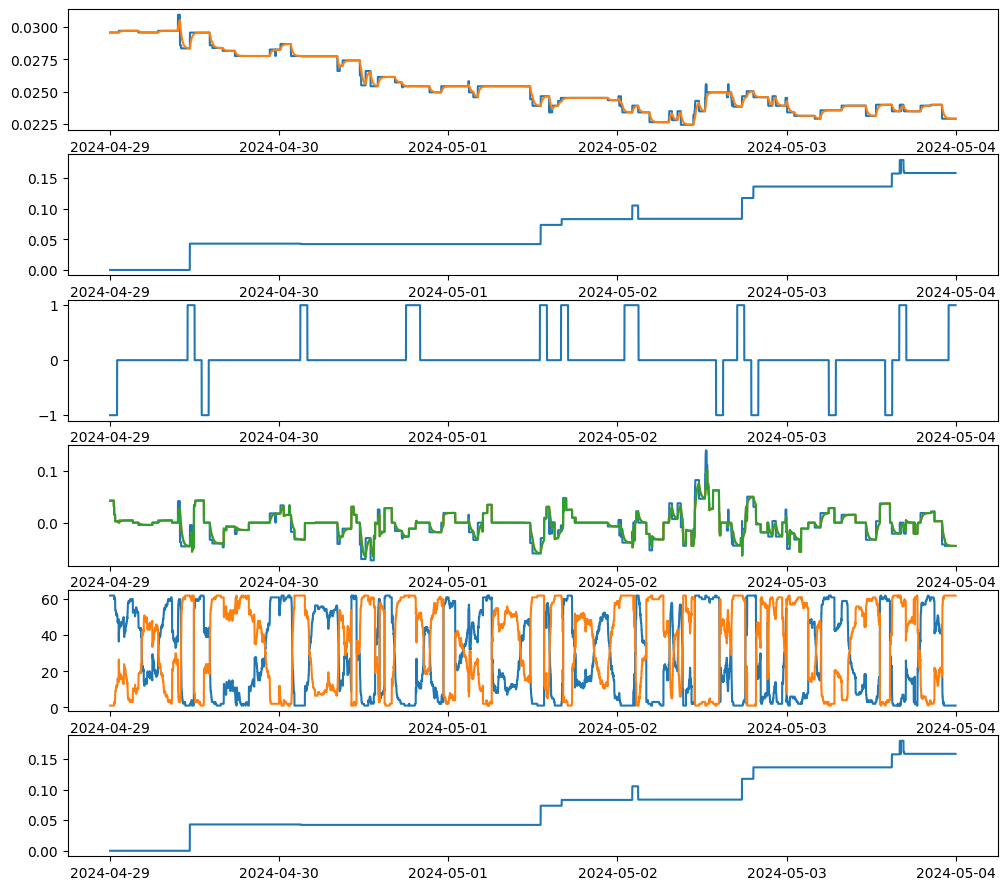

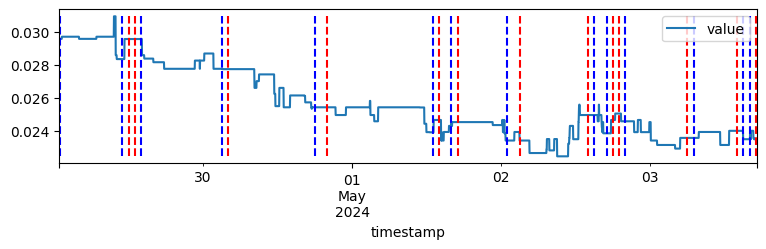

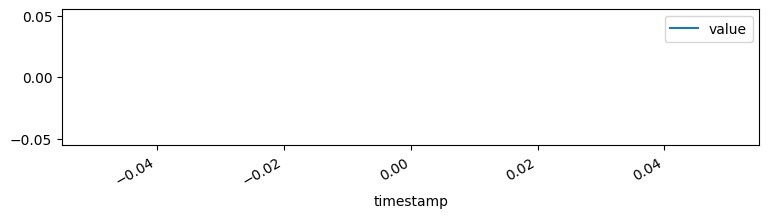

In [144]:
df_feature, df_trading = algo.alpha.momentum_common.research.investigate_symbol(
    dfst_feature, symbol_investigate, add_trading_columns_func=algo.alpha.momentum_reversal.research.add_trading_columns, trading_param=trading_param, figsize=(12, 11))

note that the volume is very miniscule and what the algo captures is the 

<AxesSubplot:xlabel='timestamp'>

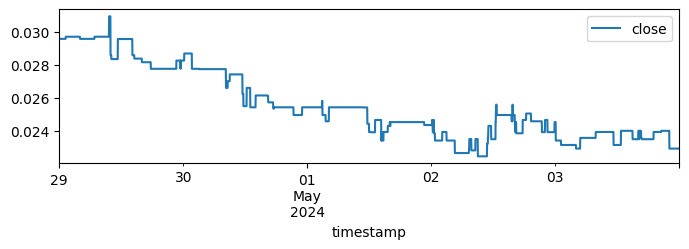

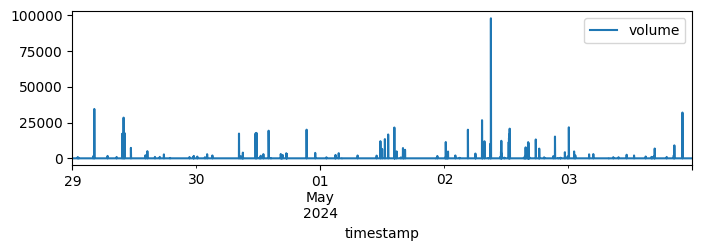

In [149]:
df_feature[['close']].plot(figsize=(8,2))
df_feature[['volume']].plot(figsize=(8,2))

In [39]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-04-01 05:00:00-04:00,0.08360,-1,-1.0,0.0,0.0
2024-04-01 11:00:00-04:00,0.07848,0,1.0,-0.0,-0.0
2024-04-01 14:00:00-04:00,0.08298,1,1.0,0.0,0.0
2024-04-01 17:00:00-04:00,0.08369,0,-1.0,0.0,0.0
2024-04-01 20:00:00-04:00,0.08966,1,1.0,0.0,0.0
...,...,...,...,...,...
2024-04-27 17:00:00-04:00,0.04064,0,1.0,-0.0,-0.0
2024-04-28 17:00:00-04:00,0.03909,-1,-1.0,0.0,0.0
2024-04-28 20:00:00-04:00,0.04087,0,1.0,-0.0,-0.0


In [40]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-01 05:00:00-04:00, QRDOUSD, 0.0836, position_changed: -1.0
2024-04-01 11:00:00-04:00, QRDOUSD, 0.07848, position_changed: 1.0
2024-04-01 14:00:00-04:00, QRDOUSD, 0.08298, position_changed: 1.0
2024-04-01 17:00:00-04:00, QRDOUSD, 0.08369, position_changed: -1.0
2024-04-01 20:00:00-04:00, QRDOUSD, 0.08966, position_changed: 1.0
2024-04-01 23:00:00-04:00, QRDOUSD, 0.08524, position_changed: -1.0
2024-04-02 08:00:00-04:00, QRDOUSD, 0.07772, position_changed: -1.0
2024-04-02 11:00:00-04:00, QRDOUSD, 0.078, position_changed: 1.0
2024-04-02 14:00:00-04:00, QRDOUSD, 0.08148, position_changed: 1.0
2024-04-02 17:00:00-04:00, QRDOUSD, 0.07799, position_changed: -1.0
2024-04-03 08:00:00-04:00, QRDOUSD, 0.08081, position_changed: 1.0
2024-04-03 11:00:00-04:00, QRDOUSD, 0.07734, position_changed: -1.0
2024-04-03 14:00:00-04:00, QRDOUSD, 0.07126, position_changed: -1.0
2024-04-03 17:00:00-04:00, QRDOUSD, 0.07188, position_changed: 1.0
2024-04-04 02:00:00-04:00, QRDOUSD, 0.06933, position_chan